## Classificazione del testo

### Creazione di un dataset di esempio
Supponiamo di avere una descrizione testuale di diverse settimane in estate, inverno, primavera e autunno. Per ogni giorno della settimana, viene riportata la condizione atmosferica prevalente fra

pioggia, neve, sole, nebbia, ghiaccio, nuvoloso

In [1]:
import pandas as pd 
import numpy as np 
import ast 
import matplotlib.pyplot as plt
from scipy.special import softmax
import torch

In [2]:
weather = ['pioggia', 'neve', 'sole', 'nebbia', 'ghiaccio', 'nuvoloso']
seasons = {
    'estate': softmax([2, 1, 4, 1, 1, 2]),
    'inverno': softmax([4, 4, 1, 2, 5, 3]),
    'primavera': softmax([4, 1, 3, 1, 1, 3]),
    'autunno': softmax([3, 1, 2, 3, 1, 4]),
}
labels = list(sorted(seasons.keys()))
y = np.random.choice(labels, size=1000)
X = np.array([np.random.choice(weather, size=7, p=seasons[s]) for s in y])
data = pd.DataFrame(X)
data['target'] = y 

data.head()

,0,1,2,3,4,5,6,target
0,nebbia,sole,nuvoloso,nuvoloso,nuvoloso,nuvoloso,pioggia,autunno
1,pioggia,pioggia,sole,nuvoloso,pioggia,nuvoloso,nuvoloso,primavera
2,nebbia,nebbia,pioggia,sole,nuvoloso,nebbia,nuvoloso,autunno
3,sole,nuvoloso,sole,pioggia,pioggia,pioggia,pioggia,primavera
4,nuvoloso,pioggia,pioggia,sole,sole,sole,sole,estate


## Prodotto fra vettori e fra vettori e matrici

In [3]:
a = np.array([2, 4, 3, 6])
b = np.array([2, 4, 3, 6])

prod = 0
for i, x in enumerate(a):
    prod = prod + x * b[i]
print(prod)
print(a.dot(b))

65
65


In [4]:
a = np.array([1, 2, 3])
b = np.array([
    [2, 4],
    [1, 1],
    [0, 0]
])
print(a.dot(b))
print(a.dot(b[:,0]), a.dot(b[:,1]))

[4 6]
4 6


## Preparazione dei dati

In [5]:
category_lines = dict([(season, []) for season in labels])
for i, row in data.iterrows():
    category_lines[row.target].append(list(row[:-1].values))

In [6]:
category_lines['estate'][:2]

[['nuvoloso', 'pioggia', 'pioggia', 'sole', 'sole', 'sole', 'sole'],
 ['neve', 'sole', 'pioggia', 'sole', 'nuvoloso', 'pioggia', 'pioggia']]

In [7]:
def week2bow(week: list):
    tensor = torch.zeros(1, len(weather))
    for li, day in enumerate(week):
        tensor[0][weather.index(day)] += 1
    return tensor

def label2vec(label: str):
    tensor = torch.zeros(1, len(labels))
    tensor[0, labels.index(label)] = 1
    return tensor

def random_training_sample(embedding_function: callable):
    category = np.random.choice(labels)
    line_id = np.random.randint(0, len(category_lines[category]))
    line = category_lines[category][line_id]
    category_tensor = label2vec(category)
    line_tensor = embedding_function(line)
    return category, line, category_tensor, line_tensor

In [8]:
category, line, category_tensor, line_tensor = random_training_sample(week2bow)

In [12]:
category_tensor, line_tensor

(tensor([[0., 0., 0., 1.]]), tensor([[3., 0., 0., 0., 1., 3.]]))

In [17]:
T, X = category_tensor.detach().numpy()[0], line_tensor.detach().numpy()[0]

In [22]:
from scipy.special import softmax

In [31]:
print(labels)
print(weather)
X = np.array([7, 0, 0, 0, 0, 0, 0 ])
P = np.random.random(size=(len(X), len(T)))
print(P)
print(softmax(X.dot(P)))


['autunno', 'estate', 'inverno', 'primavera']
['pioggia', 'neve', 'sole', 'nebbia', 'ghiaccio', 'nuvoloso']
[[0.2515256  0.96153919 0.56339133 0.73537076]
 [0.47644523 0.95255672 0.77998239 0.8805763 ]
 [0.30745143 0.21074741 0.26423055 0.74742653]
 [0.7707686  0.90303389 0.54339184 0.43155002]
 [0.31038454 0.89846385 0.54787698 0.14894823]
 [0.86824041 0.97230176 0.2194799  0.12620525]
 [0.32587538 0.72394122 0.78562496 0.87464033]]
[0.00544993 0.78501105 0.0483595  0.16117951]


## Classificatore

In [33]:
import net

In [34]:
classifier = net.SimplePredictor(input_dim=len(weather), output_dim=len(labels))

In [35]:
example_label, example_week, label_vec, line_vec = random_training_sample(week2bow)
classifier(line_vec), label_vec

(tensor([[0.7499, 0.0186, 0.1778, 0.0537]], grad_fn=<SoftmaxBackward0>),
 tensor([[0., 1., 0., 0.]]))

## Training

In [36]:
history = classifier.run_training(random_training_sample, week2bow, 
                        n_iterations = 10000, plot_every = 100)

100%|██████████| 10000/10000 [00:06<00:00, 1657.03it/s]


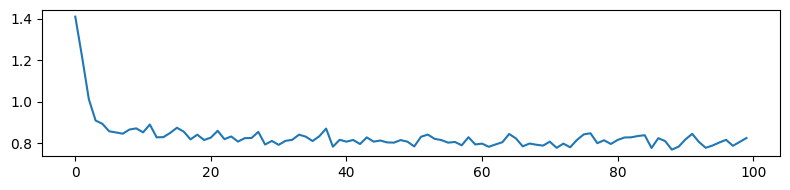

In [37]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(history)
plt.tight_layout()
plt.show()

## Valutazione

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [39]:
def interpretation(out):
    return labels[int(np.argmax(out[0]))]

In [40]:
test_size = 1000
y_true, y_pred = [], []
for i in range(test_size):
    example_label, example_week, label_vec, line_vec = random_training_sample(week2bow)
    with torch.no_grad():
        out = classifier(line_vec)
    y_true.append(example_label)
    y_pred.append(interpretation(out))

In [41]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

     autunno       0.94      0.95      0.95       273
      estate       0.92      0.98      0.95       241
     inverno       0.99      0.98      0.99       238
   primavera       0.91      0.86      0.89       248

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



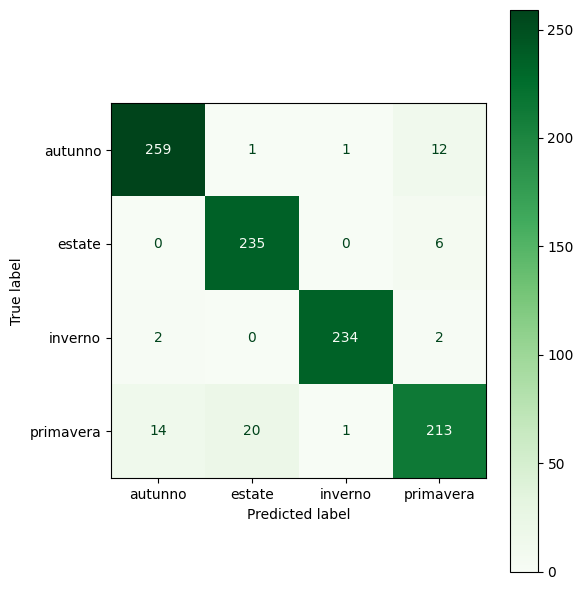

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, labels=labels, ax=ax, cmap='Greens'
)
plt.tight_layout()
plt.show()